In [15]:
from fz_text_seg import tokenization, lexical_score, find_boundaries, create_blocks
import matplotlib.pyplot as plt
import numpy as np

In [16]:
w_token = 20
k_block = 4

In [17]:
text_tokens, unique_tokens = tokenization('corpus.txt', w_token)

In [18]:
len(text_tokens)

90

In [19]:
blocks, paragraphs = create_blocks(text_tokens, k_block)
len(blocks)

23

In [20]:
lex_score, lex_score_smooth = lexical_score(blocks, unique_tokens)
depth_max_pts = find_boundaries(lex_score_smooth, len(paragraphs))

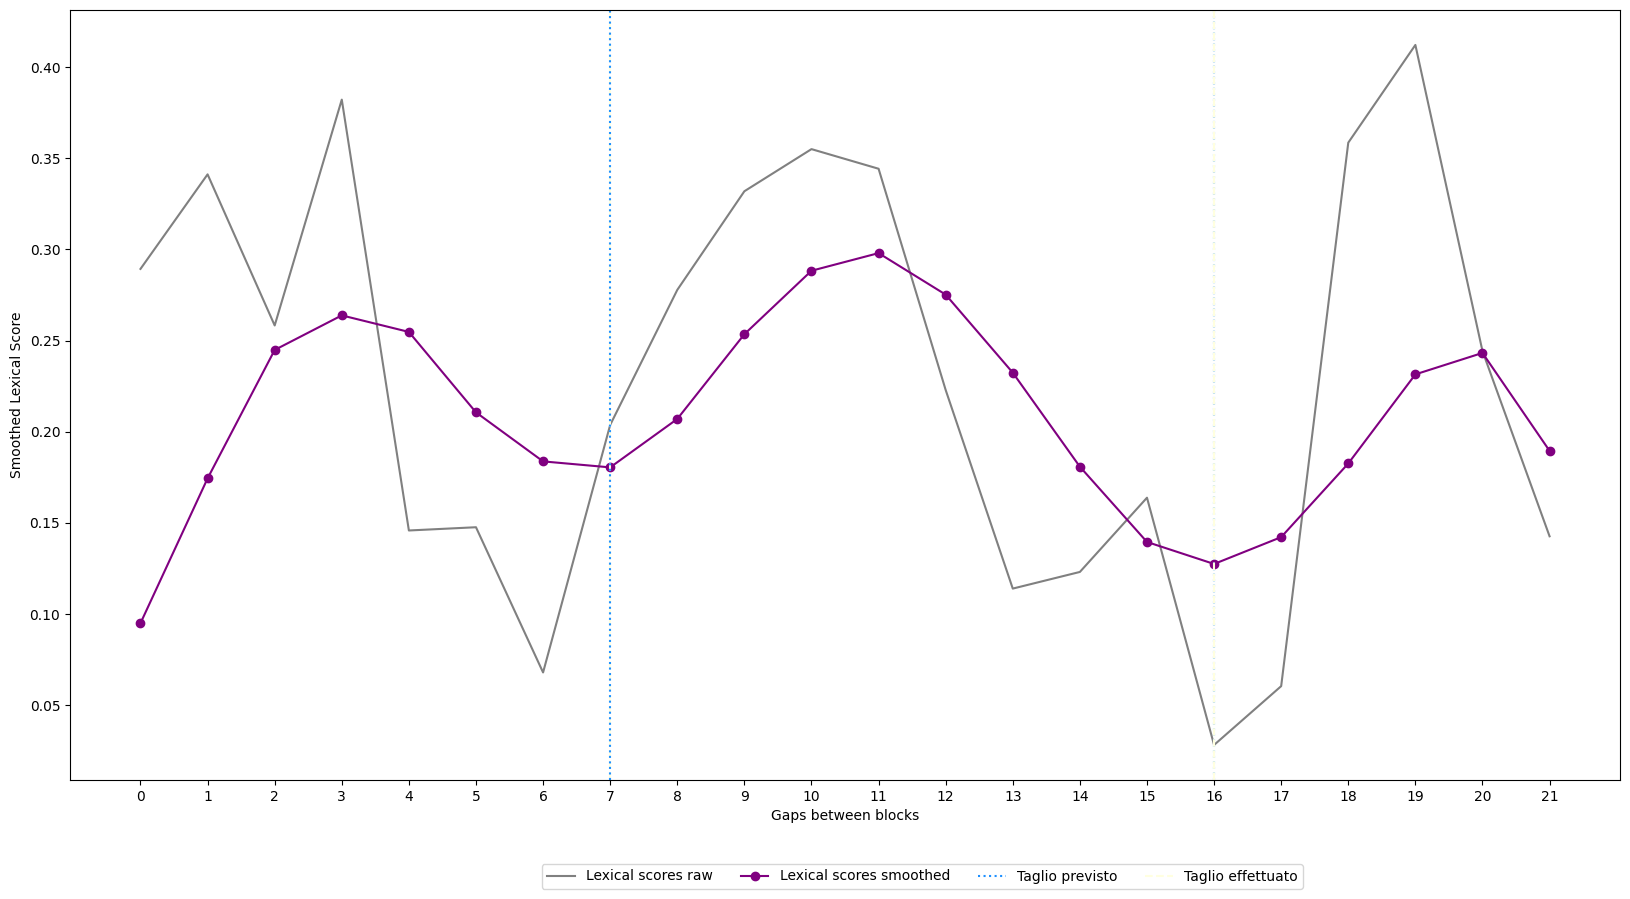

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(np.arange(0, len(lex_score)), lex_score, '-', color='grey', label='Lexical scores raw')
ax.plot(np.arange(0, len(lex_score_smooth)), lex_score_smooth, '-o', color='purple', label='Lexical scores smoothed')
x = [point[1] for point in depth_max_pts]

ax.set_xticks(np.arange(0, len(lex_score)))
plt.xlabel('Gaps between blocks')
plt.ylabel('Smoothed Lexical Score')

for i in range(len(paragraphs)):
    plt.axvline(x=x[i], linestyle='dotted', color='dodgerblue', label='Taglio effettuato')
    plt.axvline(x=paragraphs[i], linestyle='dashed', color='lightyellow', label='Taglio previsto')

ax.legend(['Lexical scores raw','Lexical scores smoothed','Taglio previsto', 'Taglio effettuato'], bbox_to_anchor=(0.8, -0.1), ncol=5)